# Multimodal Data Models

MRI and ECG data from UK Biobank:
catalog accession ids are GCST90250896 (for
cross-modal ECG and cardiac MRI unsupervised GWAS)

## Download Data

In [1]:
!pip install opendatasets
!pip install kaggle

Mount google drive to save Kaggle API credentials

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# kaggle api key
! mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/Columbia/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download khyeh0719/ptb-xl-dataset

100% 1.72G/1.72G [01:08<00:00, 33.1MB/s]
100% 1.72G/1.72G [01:08<00:00, 26.9MB/s]


In [7]:
! unzip /content/ptb-xl-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19342_hr.dat  
  inflating: ptb-xl-a-large-publicly-availabl

## Unpack Data

In [8]:
! pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.5 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import wfdb
import ast
from collections import Counter

In [10]:
! cd /content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1

In [11]:
df = pd.read_csv("/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv")

In [12]:
df = df.drop(['nurse', 'site', 'device', 'recording_date', 'report',
              'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by',
              'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
              'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
              'extra_beats', 'pacemaker', 'strat_fold'], axis=1)

In [13]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

In [14]:
df["scp_code"] = [s[s.find("'")+1:s.find("'", s.find("'")+2)] for s in df['scp_codes']]

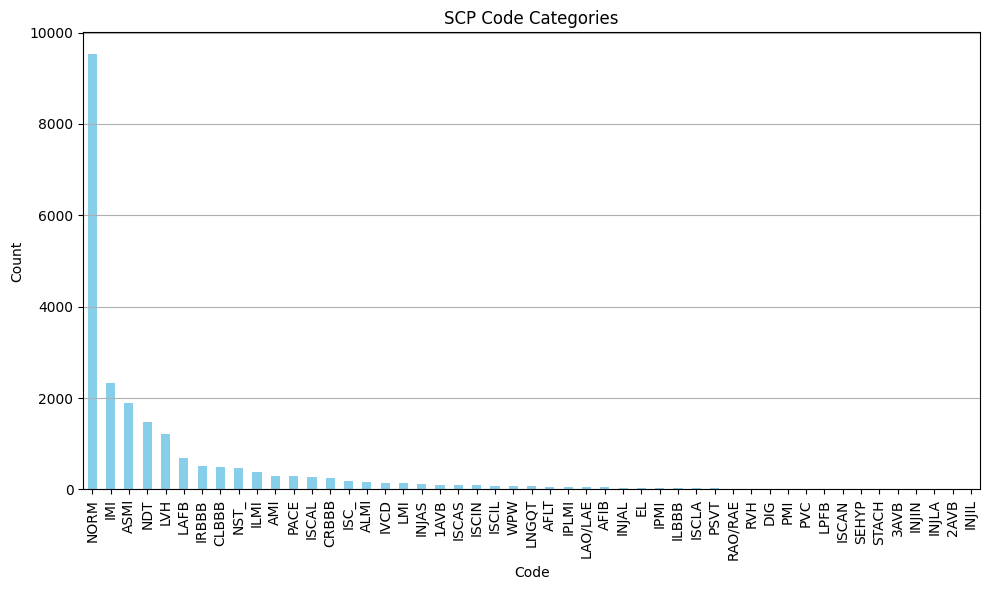

In [15]:
scp_code_values = df["scp_code"].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
scp_code_values.plot(kind='bar', color='skyblue')
plt.title('SCP Code Categories')
plt.xlabel('Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()


In [16]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,scp_codes,filename_lr,filename_hr,scp_code
0,1,15709.0,56.0,1,166.708292,63.0,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",records100/00000/00001_lr,records500/00000/00001_hr,NORM
1,2,13243.0,19.0,0,166.708292,70.0,"{'NORM': 80.0, 'SBRAD': 0.0}",records100/00000/00002_lr,records500/00000/00002_hr,NORM
2,3,20372.0,37.0,1,166.708292,69.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00003_lr,records500/00000/00003_hr,NORM
3,4,17014.0,24.0,0,166.708292,82.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00004_lr,records500/00000/00004_hr,NORM
4,5,17448.0,19.0,1,166.708292,70.0,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00005_lr,records500/00000/00005_hr,NORM


## Multimodal data representation

Input data:
- age
- sex
- height
- weight
- ECG compressed signals (raw signal data in .hea form - both low res and high res form available. In this model, we use the low res form because of computing constraints)

Output data:
- SCP Code

In [17]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models

# for more specific training
import numpy as np
import torch
import torch.nn as nn

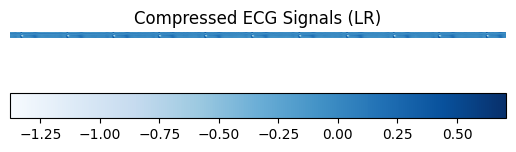

In [18]:
# Example data
fpath = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/00000/00001_lr"
data_lr = wfdb.rdsamp(fpath)

plt.imshow(data_lr[0].T, cmap='Blues')  # Use 'gray' colormap for grayscale images
cbar = plt.colorbar(orientation='horizontal')  # Add colorbar to show color scale
plt.title('Compressed ECG Signals (LR)')
plt.axis('off')  # Hide axis
plt.show()

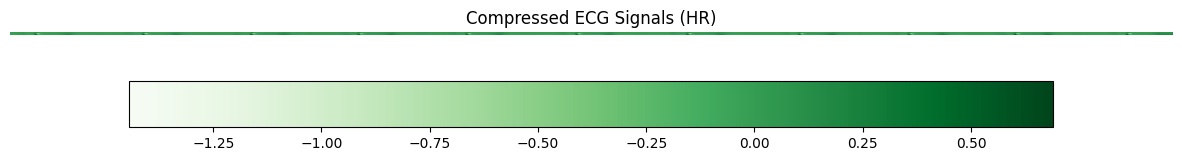

In [19]:
fpath = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/00000/00001_hr"
data_hr = wfdb.rdsamp(fpath)

plt.figure(figsize=(15, 4))

plt.imshow(data_hr[0].T, cmap='Greens')  # Use 'gray' colormap for grayscale images
cbar = plt.colorbar(orientation='horizontal')  # Add colorbar to show color scale
plt.title('Compressed ECG Signals (HR)')
plt.axis('off')  # Hide axis
plt.show()

In [20]:
print("Low res data signals: ", str(data_lr[0].shape),
      "\nHigh res data signals: ", str(data_hr[0].shape))

Low res data signals:  (1000, 12) 
High res data signals:  (5000, 12)


In [21]:
ecg_lr_path = ["/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/" + str(fn) for fn in df["filename_lr"]]

ecg_lr_data = [wfdb.rdsamp(fp)[0] for fp in ecg_lr_path]

In [22]:
ehr_columns = ['age', 'sex', 'height', 'weight']
ehr_data = df[ehr_columns].to_numpy()

In [23]:
ecg_lr_data_np = np.array(ecg_lr_data)

In [24]:
# ecg_hr_path = ["/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/" + str(fn) for fn in df["filename_hr"]]

# ecg_hr_data = np.array([wfdb.rdsamp(fp)[0] for fp in ecg_hr_path])

In [25]:
scp_code_labels = {}
labels_scp_code = {}
i=0
for code in df['scp_code'].unique():
  scp_code_labels[code] = i
  labels_scp_code[i] = code
  i+=1

In [26]:
# convert codes to numerical values
scp_data = np.array([scp_code_labels[code] for code in df['scp_code']])

In [27]:
n = ecg_lr_data_np.shape[0]
train_n = int(0.8*n)
val_n = int(0.9*n) # goes up to this amount
test_n = int(n - train_n)

In [28]:
# separate into training and testing data

# for training
x_train_ecg = ecg_lr_data_np[:train_n, :, :]  # first 80% images
x_train_ehr = ehr_data[:train_n] # first 80% records
y_train_scp = scp_data[:train_n] # first 80% scp codes (desired output)

#for validation (next 10%. last 10% reserved for testing)
x_val_ecg = ecg_lr_data_np[train_n+1:val_n, :, :]
x_val_ehr = ehr_data[train_n+1:val_n]
y_val_scp = scp_data[train_n+1:val_n]

## Model Training (Low res ECG)

In [94]:
# input layers for image and unclean label
ecg_input = tf.keras.layers.Input(shape=(1000, 12), name='ecg_input') #low res ecg
ehr_input = tf.keras.layers.Input(shape=(4,), name='ehr_input')

# cnn for image
# conv1 = tf.keras.layers.Conv2D(1000, (3, 3), activation='relu', padding='same')(ecg_input)
# conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
# pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

# conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
# conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
# pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
conv1 = tf.keras.layers.Conv1D(100, 3, activation='relu', padding='same')(ecg_input)
conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling1D(2)(conv2)

conv3 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(pool1)
conv4 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(conv3)
pool2 = tf.keras.layers.MaxPooling1D(2)(conv4)

# Flatten the pooled features
flattened_pool = tf.keras.layers.Flatten()(pool2)

# Concatenate flattened image and unclean label inputs
concatenated_inputs = tf.keras.layers.Concatenate()([flattened_pool, ehr_input])

# Add dropout for regularization
dropout1 = tf.keras.layers.Dropout(0.25)(concatenated_inputs)

# Dense layers for feature extraction
dense1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)

# Add dropout for regularization
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

# Output layer
output = tf.keras.layers.Dense(49, activation='softmax', name='output')(dropout2)

# Define the model with multiple inputs
model = tf.keras.models.Model(inputs=[ecg_input, ehr_input], outputs=output)

# Compile the model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ecg_input (InputLayer)      [(None, 1000, 12)]           0         []                            
                                                                                                  
 conv1d_28 (Conv1D)          (None, 1000, 100)            3700      ['ecg_input[0][0]']           
                                                                                                  
 conv1d_29 (Conv1D)          (None, 1000, 64)             19264     ['conv1d_28[0][0]']           
                                                                                                  
 max_pooling1d_14 (MaxPooli  (None, 500, 64)              0         ['conv1d_29[0][0]']           
 ng1D)                                                                                      

In [96]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.0001, restore_best_weights=True)
learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

# Train the model
history_model1 = model.fit([x_train_ecg,x_train_ehr], y_train_scp, epochs=10,
                          validation_data=([x_val_ecg, x_val_ehr], y_val_scp),
                                   callbacks=[early_stopping, learning_rate_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate([x_val_ecg, x_val_ehr], y_val_scp)
print('Test accuracy:', test_acc)

Epoch 1/10
546/546 [==============================] - 8s 15ms/step - loss: 2.0906 - accuracy: 0.4877 - val_loss: 1.8737 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 2/10
546/546 [==============================] - 8s 14ms/step - loss: 1.6892 - accuracy: 0.5720 - val_loss: 1.5810 - val_accuracy: 0.5896 - lr: 0.0010
Epoch 3/10
546/546 [==============================] - 8s 14ms/step - loss: 1.4479 - accuracy: 0.6288 - val_loss: 1.5201 - val_accuracy: 0.6074 - lr: 0.0010
Epoch 4/10
546/546 [==============================] - 8s 14ms/step - loss: 1.2836 - accuracy: 0.6607 - val_loss: 1.5024 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 5/10
546/546 [==============================] - 7s 13ms/step - loss: 1.1262 - accuracy: 0.6939 - val_loss: 1.5689 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 6/10
546/546 [==============================] - 8s 15ms/step - loss: 0.9766 - accuracy: 0.7243 - val_loss: 1.6038 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - 0s 6ms/step 

### Visualizations for Model 1

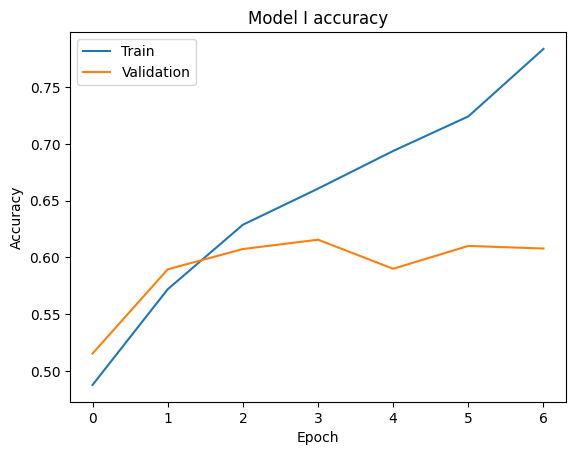

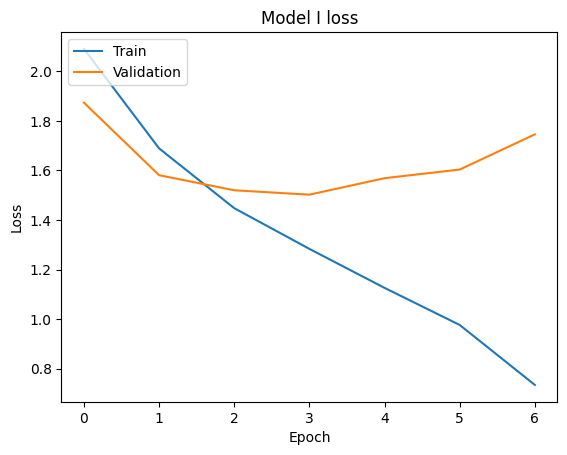

In [97]:
## Accuracy and Loss

# Plot training & validation accuracy values
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model I accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model I loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [98]:
def model_scp_predictor(ecg, ehr):
    '''
    This function should takes in the image of dimension (1000,12) and (4,) as input and returns a scp prediction
    '''
    img_data = np.zeros((1, 1000, 12))
    img_data[0] = ecg
    ehr_data = np.zeros((1,4))
    ehr_data[0] = ehr
    probs = model.predict([img_data[:1, :, :], ehr_data[:1]],verbose = 0) # verbose to stop printing the time/step line
    return np.argmax(probs)

In [99]:
# sample prediction (should output 0, true class is 0)
model_scp_predictor(ecg_lr_data_np[0], ehr_data[0])

0

In [100]:
# test set
# separate into training and testing data

#for testing (last 10% reserved for testing)
x_test_ecg = ecg_lr_data_np[val_n+1:val_n+800, :, :]
x_test_ehr = ehr_data[val_n+1:val_n+800]
y_test_scp = scp_data[val_n+1:val_n+800]

In [101]:
y_scp_pred = []

for ecg, ehr in zip(x_test_ecg, x_test_ehr):
    y_scp_pred.append(int(model_scp_predictor(ecg, ehr)))

In [102]:
# Visualization libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

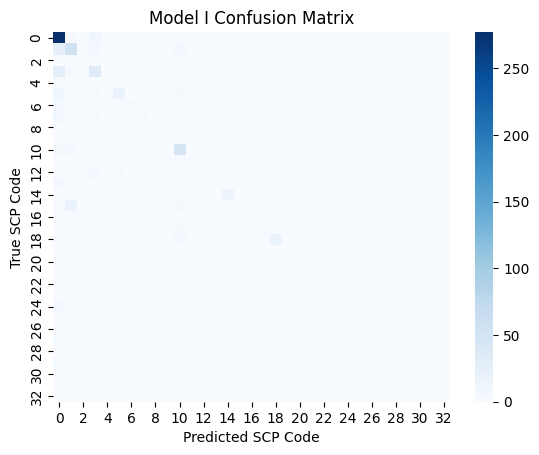

In [103]:
## Confusion Matrix

conf_matrix = confusion_matrix(y_test_scp, y_scp_pred)
sns.heatmap(conf_matrix, annot=False, cmap="Blues", fmt="d")
plt.xlabel('Predicted SCP Code')
plt.ylabel('True SCP Code')
plt.title('Model I Confusion Matrix')
plt.show()

In [104]:
model.save("model1.h5")
#np.save('ecg_lr_data_np.npy', ecg_lr_data_np)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model 3 (Low res ECG)

Tried with high res ecg signals and it just kept crashing my RAM

This model has additional layers

In [77]:
# # Input layers for image and unclean label
# ecg_input = tf.keras.layers.Input(shape=(1000, 12), name='ecg_input')  # low res ecg
# ehr_input = tf.keras.layers.Input(shape=(4,), name='ehr_input')

# # CNN for image
# conv1 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(ecg_input)
# conv1 = tf.keras.layers.BatchNormalization()(conv1)
# conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv1)
# conv2 = tf.keras.layers.BatchNormalization()(conv2)
# pool1 = tf.keras.layers.MaxPooling1D(2)(conv2)

# conv3 = tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same')(pool1)
# conv3 = tf.keras.layers.BatchNormalization()(conv3)
# conv4 = tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same')(conv3)
# conv4 = tf.keras.layers.BatchNormalization()(conv4)
# pool2 = tf.keras.layers.MaxPooling1D(2)(conv4)

# # Flatten the pooled features
# flattened_pool = tf.keras.layers.Flatten()(pool2)

# # Concatenate flattened image and unclean label inputs
# concatenated_inputs = tf.keras.layers.Concatenate()([flattened_pool, ehr_input])

# # Add dropout for regularization
# dropout1 = tf.keras.layers.Dropout(0.5)(concatenated_inputs)

# # Dense layers for feature extraction
# dense1 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
# dense1 = tf.keras.layers.BatchNormalization()(dense1)
# dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
# dense2 = tf.keras.layers.BatchNormalization()(dense2)

# # Add dropout for regularization
# dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

# # Output layer
# output = tf.keras.layers.Dense(10, activation='softmax', name='output')(dropout2)

# # Define the model with multiple inputs
# model2 = tf.keras.models.Model(inputs=[ecg_input, ehr_input], outputs=output)

# # Compile the model
# model2.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model2.summary()

# Input layers for image and unclean label
ecg_input = tf.keras.layers.Input(shape=(1000, 12), name='ecg_input')  # low res ecg
ehr_input = tf.keras.layers.Input(shape=(4,), name='ehr_input')

# Data Normalization
normalized_ecg = tf.keras.layers.BatchNormalization()(ecg_input)

# CNN for image
conv1 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(normalized_ecg)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
pool1 = tf.keras.layers.MaxPooling1D(2)(conv2)

conv3 = tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same')(pool1)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv4 = tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same')(conv3)
conv4 = tf.keras.layers.BatchNormalization()(conv4)
pool2 = tf.keras.layers.MaxPooling1D(2)(conv4)

# Flatten the pooled features
flattened_pool = tf.keras.layers.Flatten()(pool2)

# Concatenate flattened image and unclean label inputs
concatenated_inputs = tf.keras.layers.Concatenate()([flattened_pool, ehr_input])

# Add dropout for regularization
dropout1 = tf.keras.layers.Dropout(0.5)(concatenated_inputs)

# Dense layers for feature extraction
dense1 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)

# Add dropout for regularization
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

# Output layer
output = tf.keras.layers.Dense(49, activation='softmax', name='output')(dropout2)

# Define the model with multiple inputs
model3 = tf.keras.models.Model(inputs=[ecg_input, ehr_input], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model3.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ecg_input (InputLayer)      [(None, 1000, 12)]           0         []                            
                                                                                                  
 batch_normalization_26 (Ba  (None, 1000, 12)             48        ['ecg_input[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_20 (Conv1D)          (None, 1000, 128)            4736      ['batch_normalization_26[0][0]
                                                                    ']                            
                                                                                            

Epoch 1/10
546/546 [==============================] - 18s 33ms/step - loss: 1.8051 - accuracy: 0.5675 - val_loss: 1.6956 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 2/10
546/546 [==============================] - 17s 31ms/step - loss: 1.5303 - accuracy: 0.6102 - val_loss: 1.5483 - val_accuracy: 0.6033 - lr: 0.0010
Epoch 3/10
546/546 [==============================] - 17s 31ms/step - loss: 1.3607 - accuracy: 0.6386 - val_loss: 1.4397 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 4/10
546/546 [==============================] - 17s 31ms/step - loss: 1.2342 - accuracy: 0.6688 - val_loss: 1.4442 - val_accuracy: 0.6129 - lr: 0.0010
Epoch 5/10
546/546 [==============================] - 17s 31ms/step - loss: 1.1136 - accuracy: 0.6961 - val_loss: 1.4696 - val_accuracy: 0.6038 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - 1s 10ms/step - loss: 1.4397 - accuracy: 0.6111
Test Loss: 1.4396817684173584
Test Accuracy: 0.6110856533050537


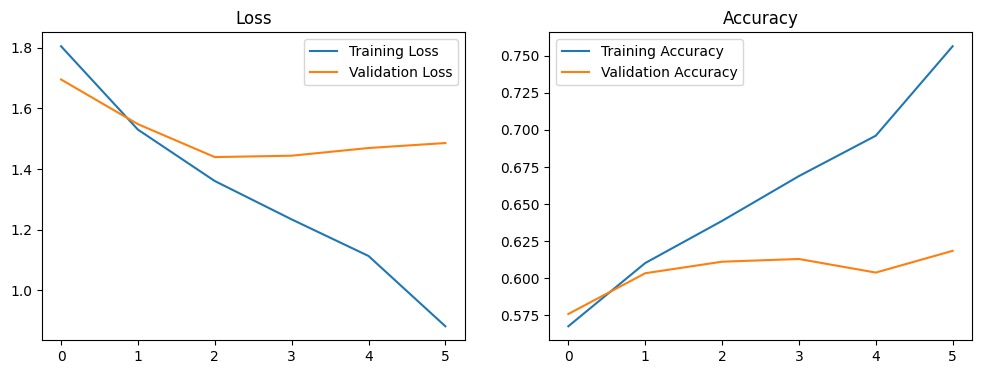

In [79]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.0001, restore_best_weights=True)
learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

# Train the model
history_model3 = model3.fit([x_train_ecg, x_train_ehr], y_train_scp, epochs=10,
                          validation_data=([x_val_ecg, x_val_ehr], y_val_scp),
                                   callbacks=[early_stopping, learning_rate_scheduler])

# Evaluate the model
loss, accuracy = model3.evaluate([x_val_ecg, x_val_ehr], y_val_scp)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_model3.history['loss'], label='Training Loss')
plt.plot(history_model3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_model3.history['accuracy'], label='Training Accuracy')
plt.plot(history_model3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [85]:
model3.save("model3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
def model3_scp_predictor(ecg, ehr):
    '''
    This function should takes in the image of dimension (1000,12) and (4,) as input and returns a scp prediction
    '''
    img_data = np.zeros((1, 1000, 12))
    img_data[0] = ecg
    ehr_data = np.zeros((1,4))
    ehr_data[0] = ehr
    probs = model3.predict([img_data[:1, :, :], ehr_data[:1]],verbose = 0) # verbose to stop printing the time/step line
    return np.argmax(probs)

In [84]:
# test set
# separate into training and testing data

#for testing (last 10% reserved for testing)
x_test_ecg = ecg_lr_data_np[val_n+1:val_n+800, :, :]
x_test_ehr = ehr_data[val_n+1:val_n+800]
y_test_scp = scp_data[val_n+1:val_n+800]

In [86]:
y_scp_pred3 = []

for ecg, ehr in zip(x_test_ecg, x_test_ehr):
    y_scp_pred3.append(int(model3_scp_predictor(ecg, ehr)))

In [89]:
mae = np.mean(np.abs(y_scp_pred3 - y_test_scp))
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 3.4317897371714645


In [90]:
# test accuracy
diff = 0

for i in range(0, len(y_scp_pred3)):
  if y_scp_pred3[i]!= y_test_scp[i]:
    diff+=1

print("Test accuracy: ", (diff/len(y_scp_pred3)))

Test accuracy:  0.39173967459324155


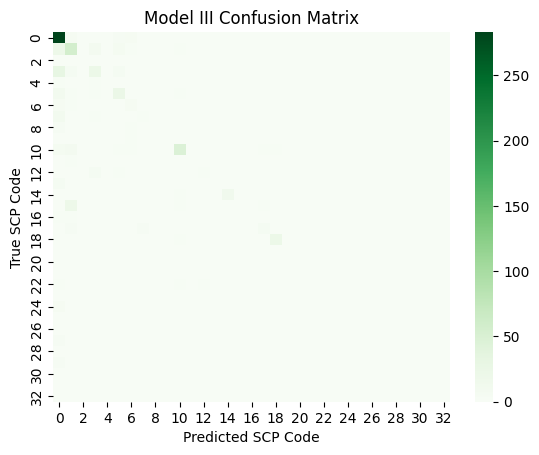

In [92]:
## Confusion Matrix

conf_matrix = confusion_matrix(y_test_scp, y_scp_pred3)
sns.heatmap(conf_matrix, annot=False, cmap="Greens", fmt="d")
plt.xlabel('Predicted SCP Code')
plt.ylabel('True SCP Code')
plt.title('Model III Confusion Matrix')
plt.show()